<p align="center">
    <!--If notebook is in folder notebooks change scr by "../images/logo.png"-->
  <img width="100" height="100" src="../images/logo.png">
</p>

<div>
<h1>05. Optimización del modelo</h1> 

Canadian Car Accidents Practice <br>
<strong>Aprendizaje Automático</strong> <br>
<strong>Master Universitario en Ciencia de Datos</strong>
</div>

<div style='text-align:right'>Álvaro Serrano del Rincón (<i>a.serranodelrincon@cunef.edu</i>)</div>
<div style='text-align:right'>Carlos Viñals Guitart (<i>carlos.vinals@cunef.edu</i>)</div>

---


## 5.0 Introducción

A continuación, procederemos a realizar la optimización del modelo ganador que pudimos obtener en el apartado anterior. Para ello nos centraremos en los hiperparámetros del mismo y seleccionaremos la métrica adecuada que permita poder utilizarlo.

Para este trabajo estamos utilizando un entorno de propósito espécifico.

In [1]:
!conda info


     active environment : ML_P1
    active env location : C:\Users\carviagu\anaconda3\envs\ML_P1
            shell level : 2
       user config file : C:\Users\carviagu\.condarc
 populated config files : 
          conda version : 4.10.3
    conda-build version : 3.21.4
         python version : 3.8.8.final.0
       virtual packages : __cuda=11.3=0
                          __win=0=0
                          __archspec=1=x86_64
       base environment : C:\Users\carviagu\anaconda3  (writable)
      conda av data dir : C:\Users\carviagu\anaconda3\etc\conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/win-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/win-64
                          https://repo.anaconda.com/pkgs/r/noarch
                          https://repo.anaconda.com/pkgs/msys2/win-64
                          https://repo.anaconda.com/pkgs/msys2/no

### 5.0.1 Estructura

## Librerías

In [1]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search
import pickle

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

## Scripts

In [2]:
import sys

import sys  
sys.path.insert(0, '../scripts/')

import csv_tools
import model_tools

## 5.1 Modelo y datos
Vamos a revisar los datos y el modelo a utilizar.

### 5.1.1 Datos
Utilizamos las muestras preparadas anteriormente y que nos permitieron elaborar el modelo inicial.

In [24]:
full_train = pd.read_csv("../data/csev/fulltrainCSEVscal.csv")
full_test = pd.read_csv("../data/csev/fulltestCSEVscal.csv")

In [25]:
Y_train = full_train['C_SEV']
X_train = full_train.drop(['C_SEV'], axis=1)
Y_train.value_counts()

0    27794
1    27794
Name: C_SEV, dtype: int64

In [26]:
Y_test = full_test['C_SEV']
X_test = full_test.drop(['C_SEV'], axis=1)
Y_test.value_counts()

1    351139
0      6949
Name: C_SEV, dtype: int64

### 5.1.2 Modelo: XGBoost
Hacemos uso de un XGBoost que fue el modelo ganador al obtener el mejor *recall* y presentar un area ROC adecuada para poder realizar mejoras al mismo durant el proceso de optimización de hiperparámetros.

In [27]:
filename = '../models/xgb_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [28]:
Y_pred = loaded_model.predict(X_test)
print("XGBoost Accuracy: ", metrics.recall_score(Y_test, Y_pred))
print("XGBoost Recall: ", metrics.recall_score(Y_test, Y_pred,
                                               zero_division = 0.0, labels=[0], average='weighted'))
print("XGBoost ROC_AUC: ", metrics.roc_auc_score(Y_test, loaded_model.predict_proba(X_test)[:,1]))

ValueError: Feature shape mismatch, expected: 15, got 14

## 5.2 Optimización
Ahora procederemos a realizar la optimización de hiperparámetros del modelo XGBoost. Para ello primero analizaremos las ideas básicas de los parametros de optimización que este modelo posee y podamos entender el trabajo de mejora que realizamos.


### 5.2.1 Conceptos
Previamente repasamos algunos conceptos relacionados con este modelo y sus hiperparámetros que explican las decisiones tomadas para encontrar el óptimo. En concreto nos centraremos en los parámetros que utilizamos para mejorar el modelo.

XGBoost hace uso de tres grupos de parámetros:
* **Generales**
* **Booster**
* **Aprendizaje**

Los primeros hacen referencia a aspectos universales del modelo. No nos centraremos en estos pues no los consideramos relavantes teniendo en cuanta que se refieren a aspectos de rendimiento y salida, que no podemos manejar de manera propicia con nuestro equipo actual.

Los segundos son muy relevantes y son los que probaremos extensivamente para encontrar mejoras. Destacamos:
* **learning rate**: Hace el modelo más robusto, valores aconsejables entorno al 0.01 y 0.2
* **min_child_weight**: Mínimo de observaciones requeridas en un hijo de una rama (por peso). Permite controlar el over-fitting.
* **max_depth**: Profundidad de los árboles. Permite controlar el over-fitting.
* **gamma**: Mínima reducción de pérdida (*loss*) para hacer discriminaciones.
* **sumsample**: Fracción de observaciones para cada árbol del modelo.
* **colsample_bytree**: Fracción de columnas para cada árbol del modelo.
* **reg_alpha**: Regularización de Lasso para el modelo.

Por último, los parametros de aprendizaje son pocos y no se modificarán, al igual que los génericos. Estos son:
* **objetive**: Tipo de clasificación, en nuesto caso *binary:logistic*.
* **eval_metric**: Evaluación utilizada, acorde con el objetivo. *error* en nuestro caso.
* **seed**: Semilla, utilizamos valor 0, como en otras ocasiones.

Más información en las siguinetes referencias:
* XGBoost Tunning: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
* Gradient Boosting: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/#h2_7
* Documentación XGBoost: https://xgboost.readthedocs.io/en/latest/python/python_api.html

### 5.2.2 *Tunning* de parámetros
Ahora procedemos a realizar el tunning de los parámetros. Para ello creamos una función de evaluación de modelos que nos servirá para ir verificando las mejoras obtenidas. Esta hará uso de Validación Cruzada para mejorar el modelo y obtener el score. A modo general nos centraremos en este método en evaluar siguiendo la métrica del área de la curva ROC, es decir, el AUC (*Area Under Curve*).

In [8]:
def modelfit(alg, X_train, Y_train, X_test, Y_test, cv_folds=5, early_stopping_rounds=50):

    # Validación cruzada
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(X_train.values, label=Y_train.values)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='auc', early_stopping_rounds=early_stopping_rounds)
    alg.set_params(n_estimators=cvresult.shape[0])

    # Fit
    alg.fit(X_train, Y_train, eval_metric='auc')

    # Predicción de Train
    train_pred = alg.predict(X_train)
    train_predprob = alg.predict_proba(X_train)[:,1]

    # Métricas del modelo
    print("\nModel Report")
    print("Accuracy (Train): %.4g" % metrics.accuracy_score(Y_train, train_pred))
    print("Recall (Train): %f" % metrics.recall_score(Y_train, train_pred, pos_label=0))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(Y_train, train_predprob))

    # Predicción de Test
    test_pred = alg.predict(X_test)
    test_predprob = alg.predict_proba(X_test)[:,1]

    print("Accuracy (Test): %.4g" % metrics.accuracy_score(Y_test, test_pred))
    print("Recall (Test): %f" % metrics.recall_score(Y_test, test_pred, pos_label=0))
    print("AUC Score (Test): %f" % metrics.roc_auc_score(Y_test, test_predprob))

    # Importancia de variables del modelo
    xgb.plot_importance(alg)
    plt.show()

    # Matriz de confusion
    titles_options = [
        ("Matriz de confusión", None),
        ("Matriz de confusión normalizada", "true"),
    ]
    model_tools.confusion_matrix(titles_options, Y_test, test_pred, ['Fallecidos', 'No Fallecidos'])
    return alg

Creamos un diccionario que guardará los modelos para realizar más adelante una evaluación conjunta.

In [9]:
models = {}
models['XGB0'] = loaded_model

#### 5.2.2.1 Modelo inicial
Primero repasamo el modelo inicial, pues será nuestro punto de partida para poder comparar más adelante las mejoras obtenidas. Los parámetros que, por defecto, se establecieron en el mismo serán los que utilizaremos inicialmente para ir optimizandolos.


In [10]:
print(loaded_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)



Model Report
Accuracy (Train): 0.6947
Recall (Train): 0.722638
AUC Score (Train): 0.767197
Accuracy (Test): 0.6561
Recall (Test): 0.709311
AUC Score (Test): 0.751333


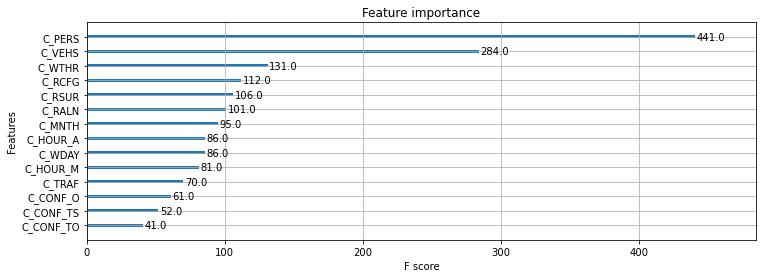

Matriz de confusión
[[  4929   2020]
 [121144 229995]]
Matriz de confusión normalizada
[[0.70931069 0.29068931]
 [0.34500298 0.65499702]]


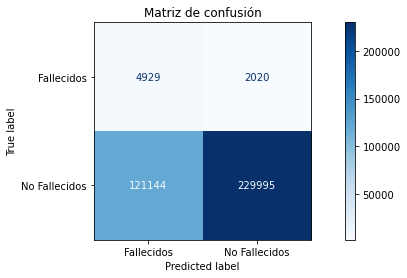

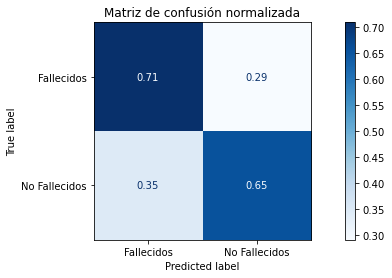

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=45, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [29]:
modelfit(loaded_model, X_train, Y_train, X_test, Y_test)

#### 5.2.2.2 Mejora centrada en AUC
Primero realizaremos una mejora centrada en la métrica Recall. Sin embargo, nuesto GridSearchCV hará uso del AUC también. Nuestro objetivo ahora mismo es ver si podemos mejorar la predicción de fallecimientos del modelo.

Comenzamos modificando el parámetro **reg_alpha**

In [18]:
# Tune reg_alpha
param_test1 = {
    'reg_alpha': [0.1, 0.5, 1, 1.5, 2, 2.5, 3]
}
scores = {'AUC': "roc_auc"}

gsearch1 = GridSearchCV(estimator = loaded_model,
                        param_grid = param_test1, scoring=scores, n_jobs=8, cv=5, refit='AUC')
gsearch1.fit(X_train, Y_train)
gsearch1.best_params_, gsearch1.best_score_

({'reg_alpha': 2.5}, 0.752057908770686)

Observamos como hemos obtenido unos valores óptimos en la búsqueda. Ahora verificamos el nuevo modelo optimizado.


Model Report
Accuracy (Train): 0.6966
Recall (Train): 0.720119
AUC Score (Train): 0.767948
Accuracy (Test): 0.6604
Recall (Test): 0.704130
AUC Score (Test): 0.751689


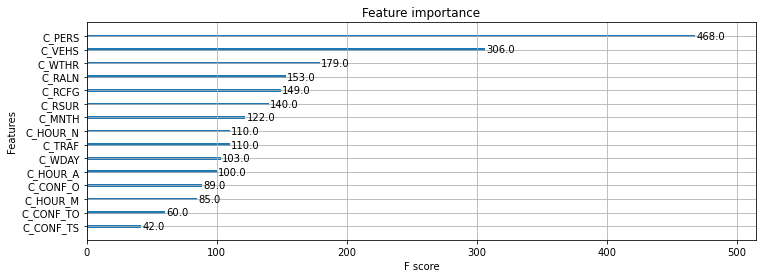

Matriz de confusión
[[  4893   2056]
 [119542 231597]]
Matriz de confusión normalizada
[[0.70413009 0.29586991]
 [0.34044068 0.65955932]]


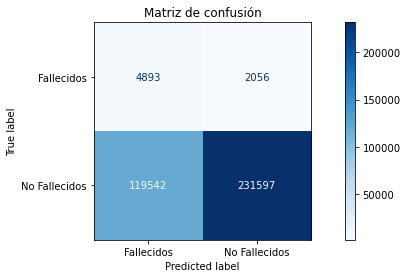

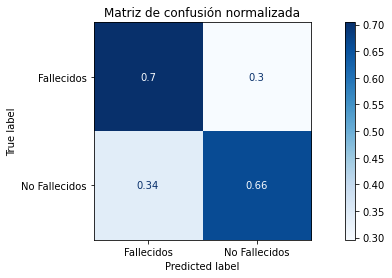

In [17]:
xgb1 = XGBClassifier(
    reg_alpha=2.5,
    n_estimators=45,
    objective= 'binary:logistic',
    eval_metric='error',
    use_label_encoder=False
)

model1 = modelfit(xgb1, X_train, Y_train, X_test, Y_test) 

In [19]:
models['XGB1'] = model1

Observamos una mejora del AUC acompañada de un pequeño equilibrado de las predicciones. Seguidamente nos centramos en el parámetro **gamma**.

In [20]:
# Tune gamma
param_test2 = {
    'gamma': [i/10 for i in range(1,10)]
}
scores = {'AUC': "roc_auc"}

gsearch2 = GridSearchCV(estimator = xgb1,
                        param_grid = param_test2, scoring=scores, n_jobs=8, cv=5, refit='AUC')
gsearch2.fit(X_train, Y_train)
gsearch2.best_params_, gsearch2.best_score_

({'gamma': 0.6}, 0.7523019358765058)


Model Report
Accuracy (Train): 0.6952
Recall (Train): 0.716018
AUC Score (Train): 0.766654
Accuracy (Test): 0.6625
Recall (Test): 0.701828
AUC Score (Test): 0.752041


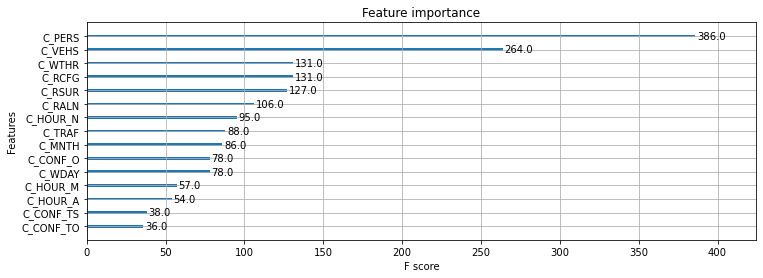

Matriz de confusión
[[  4877   2072]
 [118765 232374]]
Matriz de confusión normalizada
[[0.7018276  0.2981724 ]
 [0.33822788 0.66177212]]


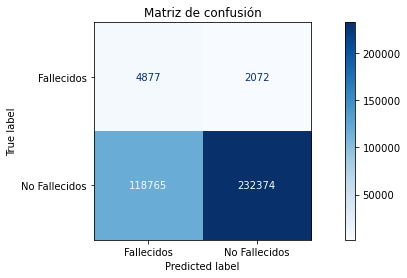

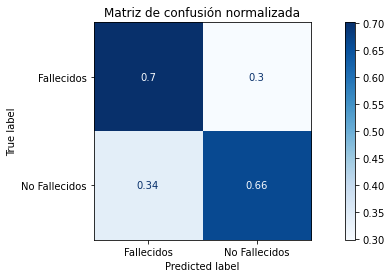

In [21]:
xgb2 =  XGBClassifier( 
    reg_alpha=2.5,
    n_estimators=45,
    objective= 'binary:logistic',
    eval_metric='error',
    use_label_encoder=False,
    gamma=0.6
)

model2 = modelfit(xgb2, X_train, Y_train, X_test, Y_test) 

In [22]:
models['XGB2'] = model2

Gracias a la optimización del parámetro gamma hemos podido observar como se ha recuperado el porcentaje de predicción anterior de Fallecidos, sin perder porcentaje de predicción en la clase No Fallecidos. Este modelo resulta un avance importante respecto a la versión inicial.

Ahora probamos si otros parámetros porporcionan mejoras considerables al modelo. 

In [23]:
# Tune max_depth and min_child_weight
param_test3 = {
    'max_depth': range(1,10),
    'min_child_weight': range(1,20)
}
scores = {'AUC': "roc_auc"}

gsearch3 = GridSearchCV(estimator = xgb1,
                        param_grid = param_test3, scoring=scores,n_jobs=8, cv=5, refit='AUC')
gsearch3.fit(X_train, Y_train)
gsearch3.best_params_, gsearch3.best_score_

({'max_depth': 6, 'min_child_weight': 5}, 0.7528043206998964)


Model Report
Accuracy (Train): 0.691
Recall (Train): 0.714003
AUC Score (Train): 0.760678
Accuracy (Test): 0.6598
Recall (Test): 0.701972
AUC Score (Test): 0.750157


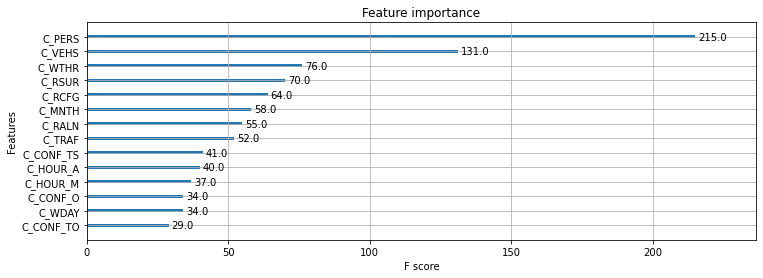

Matriz de confusión
[[  4878   2071]
 [119761 231378]]
Matriz de confusión normalizada
[[0.70197151 0.29802849]
 [0.34106436 0.65893564]]


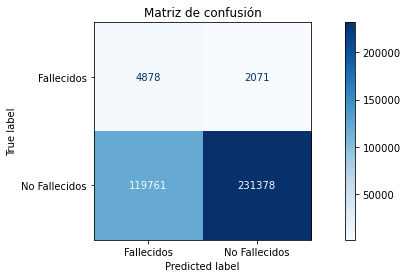

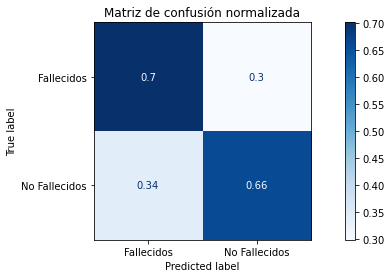

In [51]:
xgb3 =  XGBClassifier( 
    reg_alpha=1.5,
    n_estimators=45,
    objective= 'binary:logistic',
    eval_metric='error',
    use_label_encoder=False,
    gamma=0.8,
    max_depth=5,
    min_child_weight=11
)

model3 = modelfit(xgb3, X_train, Y_train, X_test, Y_test) 

In [54]:
models['XGB3'] = model3

Esta optimización no aporta cambios significiativos e incluso puede llegar a reducir el valor de las predicciones. No es una optmización adecuada para nuestro objetivo.

Podemos analizar otros parámetros como **subsample**:

In [53]:
# Tune subsample
param_test4 = {
    'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}
scores = {'AUC': "roc_auc"}

gsearch4 = GridSearchCV(estimator = xgb2,
                        param_grid = param_test4, scoring=scores,n_jobs=8, cv=5, refit='AUC')
gsearch4.fit(X_train, Y_train)
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.7, 'subsample': 0.9}, 0.7528528280086034)


Model Report
Accuracy (Train): 0.6941
Recall (Train): 0.718428
AUC Score (Train): 0.765355
Accuracy (Test): 0.6587
Recall (Test): 0.707008
AUC Score (Test): 0.751224


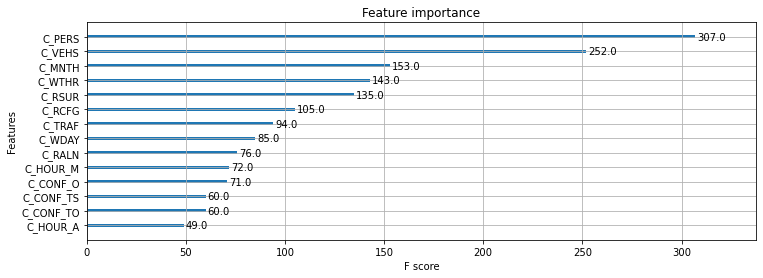

Matriz de confusión
[[  4913   2036]
 [120182 230957]]
Matriz de confusión normalizada
[[0.7070082  0.2929918 ]
 [0.34226332 0.65773668]]


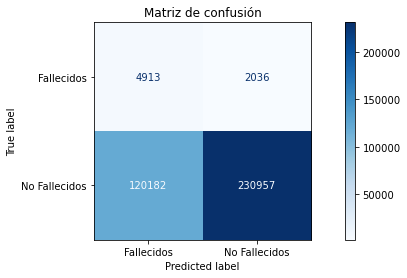

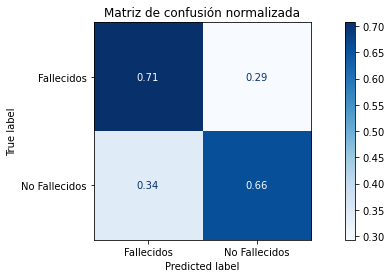

In [55]:
xgb4 =  XGBClassifier( 
    reg_alpha=1.5,
    n_estimators=45,
    objective= 'binary:logistic',
    eval_metric='error',
    use_label_encoder=False,
    gamma=0.8,
    subsample=0.9,
    colsample_bytree=0.7
)

model4 = modelfit(xgb4, X_train, Y_train, X_test, Y_test) 

In [56]:
models['XGB4'] = model4

Si bien el modelo mantiene las proporciones en su matriz de confusión, no presenta la mayor curva ROC por lo que esta optimización no es adecuada.

## 5.3 Conclusiones

Analizando los modelos obtenidos mediante la optimización realizada, podemos destacar al modelo 2, como el modelo mejor optimizado, pues es el que mayor curva ROC presenta. Se muestra la siguiente tabla comparativa:

In [86]:
def models_summary(models = None):
    scores = pd.DataFrame(data = models.keys(), columns = ['Models'], index = [0, 1, 2, 3, 4])

    pres = list()
    rec = list()
    roc = list()
    tp = list()
    tn = list()

    for key in models:
        Y_pred = models[key].predict(X_test)
        # Precision
        pres.append(metrics.precision_score(Y_test, Y_pred, zero_division = 0.0, labels=[0], average='weighted'))
        # Recall
        rec.append(metrics.recall_score(Y_test, Y_pred, zero_division = 0.0, labels=[0], average='weighted'))
        # RocAUC
        roc.append(metrics.roc_auc_score(Y_test, models[key].predict_proba(X_test)[:,1]))
        
        # Confusion Matrix
        cf = metrics.confusion_matrix(Y_test, Y_pred, normalize='true')
        tp.append(cf[[0]][0][0])
        tn.append(cf[[1]][0][1])

    scores['Precision'] = pres
    scores['Recall'] = rec
    scores['Roc_Auc'] = roc
    scores['TP'] = tp
    scores['TN'] = tn
    
    return scores

models_summary(models)

,Models,Precision,Recall,Roc_Auc,TP,TN
0,XGB0,0.039096,0.709311,0.751333,0.709311,0.654997
1,XGB1,0.039450,0.701828,0.751028,0.701828,0.661818
2,XGB2,0.039153,0.705425,0.751276,0.705425,0.657406
3,XGB3,0.039137,0.701972,0.750157,0.701972,0.658936
4,XGB4,0.039274,0.707008,0.751224,0.707008,0.657737


Se observa como el mejor modelo siguiendo las métricas de Recall y Roc_AUC es el original. Sin embargo haciendo siguiendo la matriz de confusión, que por razones del importante desbalanceo existente en los datos debemos de utilizar principalmente. La segunda optimización muestra unos valores ligeramente equilibrados que nos hacen decantarnos por este como modelo final. 

In [88]:
file_name = "../models/xgb_opt_model.sav"
pickle.dump(models['XGB2'], open(file_name, "wb"))

---

<div style='text-align:center'>Elaborado por Álvaro Serrano del Rincón (<i>a.serranodelrincon@cunef.edu</i>)</div> 
<div style='text-align:center'>y Carlos Viñals Guitart (<i>carlos.vinals@cunef.edu</i>)</div> 